<a href="https://colab.research.google.com/github/softmurata/fashionML/blob/main/diffusers/posereferenceonly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q diffusers transformers accelerate
!pip install -q controlnet_aux

In [ ]:
%cd /content
!git clone https://github.com/huggingface/diffusers.git mydiffusers

In [ ]:
%cd /content/mydiffusers/examples/community
from stable_diffusion_controlnet_reference import StableDiffusionControlNetReferencePipeline
from diffusers import ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector, LineartDetector

controlnet_name = "control_v11p_sd15_lineart" # "control_v11p_sd15_openpose"
controlnet = ControlNetModel.from_pretrained(f"lllyasviel/{controlnet_name}", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetReferencePipeline.from_pretrained(
       "SG161222/Realistic_Vision_V6.0_B1_noVAE",
       controlnet=controlnet,
       safety_checker=None,
       torch_dtype=torch.float16
       ).to('cuda:0')

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# preprocessor = OpenposeDetector.from_pretrained("lllyasviel/Annotators")
preprocessor = LineartDetector.from_pretrained("lllyasviel/Annotators")

In [ ]:
!wget https://luvbridal.com.au/wp-content/uploads/2020/09/BAILEY-ML19377-FULL-LENGTH-SLIM-A-LINE-SILHOUETTE-FLORAL-LACE-WITH-PLUNGING-V-NECKLINE-AND-FIT-FLARE-SKIRT-WITH-DETACHABLE-OVERSKIRT-INCLUDED-WEDDING-DRESS-MADI-LANE-BRIDAL7.jpg -O /content/wedding.jpg

In [ ]:
!wget https://i.pinimg.com/550x/a3/8c/7e/a38c7ec15523df0eb834844fdafbfb9c.jpg -O /content/model.jpg

In [ ]:
!wget https://dressroomami.com/new_img/news_img/20180722171628822.jpg -O /content/model001.jpg

In [ ]:
!wget https://www.photolibrary.jp/mhd3/img795/450-20200919130932215351.jpg -O /content/model.jpg

In [ ]:
from PIL import Image
pose_image = Image.open("/content/nanao.jpg").convert("RGB")
preprocess_image = preprocessor(pose_image)
input_image = Image.open("/content/wedding.jpg").convert("RGB")

generator = torch.manual_seed(-1)

result_img = pipe(
    ref_image=input_image,
    prompt="1girl, best quality",
    negative_prompt="bad faces, bad eyes, bad noses, bad hands, worst quality",
    image=preprocess_image,
    num_inference_steps=50,
    reference_attn=True,
    reference_adain=True,
    generator=generator,
    style_fidelity=0.5,
).images[0]

display(result_img)

In [ ]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

ref_controlnet = ControlNetModel.from_pretrained('lllyasviel/control_v11f1e_sd15_tile',
                                             torch_dtype=torch.float16)
ref_pipe = DiffusionPipeline.from_pretrained("SG161222/Realistic_Vision_V6.0_B1_noVAE",
                                         custom_pipeline="stable_diffusion_controlnet_img2img",
                                         controlnet=ref_controlnet,
                                         torch_dtype=torch.float16).to('cuda')

  0%|          | 0/16 [00:00<?, ?it/s]

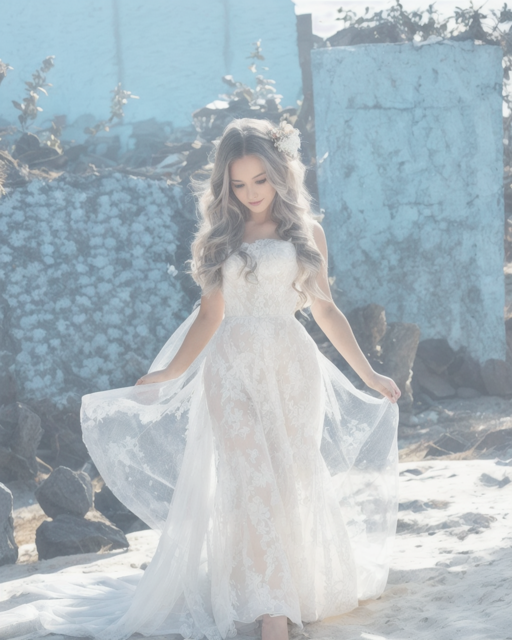

In [ ]:
source_image = Image.open("/content/a_output.png").convert("RGB")
ssize = source_image.size
condition_image = resize_for_condition_image(source_image, 1024)
image = ref_pipe(prompt="best quality",
              negative_prompt="blur, lowres, bokeh, ugly, bad anatomy, bad hands, cropped, worst quality, exorbitant",
              image=condition_image,
              controlnet_conditioning_image=condition_image,
              width=condition_image.size[0],
              height=condition_image.size[1],
              strength=0.5,
              generator=torch.manual_seed(0),
              num_inference_steps=32,
).images[0]

new_image = image.resize(ssize)
display(new_image)

In [ ]:
new_image.save("/content/b_output.png")

In [ ]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import torch.nn as nn
import numpy as np
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
bg_img = Image.open("/content/model001.jpg")
image = Image.open("/content/b_output.png").convert("RGB").resize(bg_img.size)
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

target_label_id = model.config.label2id["Dress"]
target_pred_map = np.where(pred_seg.detach().cpu().numpy() == target_label_id, 255, 0)
display(Image.fromarray(target_pred_map.astype(np.uint8)))

In [ ]:
import cv2
bg_img = cv2.imread("/content/model001.jpg")
bh, bw = bg_img.shape[:2]
fg_img = cv2.resize(cv2.imread("/content/b_output.png"), (bw, bh))
fh, fw = fg_img.shape[:2]

sel_mask = target_pred_map

w = min(fg_img.shape[1], bg_img.shape[1])
h = min(fg_img.shape[0], bg_img.shape[0])

fg_roi = fg_img[:h, :w]
bg_roi = bg_img[:h, :w]

bg_roi[:] = np.where(sel_mask[:h, :w, np.newaxis] == 0, bg_roi, fg_roi)

answer_rgb = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
display(Image.fromarray(answer_rgb))

Inference

In [ ]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import torch.nn as nn
import numpy as np
from PIL import Image
import cv2
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
image = Image.open("/content/wedding.jpg").convert("RGB")
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

target_label_id = model.config.label2id["Dress"]
target_pred_map = np.where(pred_seg.detach().cpu().numpy() == target_label_id, 255, 0).astype(np.uint8)
display(Image.fromarray(target_pred_map))

In [ ]:
def calculate_bounding_box(mask_image):

    # 二値化処理を行い、輪郭を抽出
    _, contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("輪郭が見つかりません。")
        return None

    # 最大面積の輪郭を選択
    max_contour = max(contours, key=cv2.contourArea)

    # 輪郭を囲む最小の矩形を計算
    bounding_box = cv2.boundingRect(max_contour)

    return bounding_box

# マスク画像のファイルパス
mask_image = target_pred_map

# bounding box を計算
result = calculate_bounding_box(mask_image_path)

if result is not None:
    x, y, w, h = result

In [ ]:
colors = [30, 80, 130, 180, 230]
for idx, c in enumerate(colors):
  fg_img = cv2.imread("/content/wedding.jpg")
  fh, fw = fg_img.shape[:2]
  bg_img = np.zeros((fh, fw, 3), dtype=np.uint8)
  base_color_idx = np.random.randint(0, 3)
  base_color = [0, 0, 0]
  base_color[base_color_idx] = c
  bg_img[:, :] = base_color  # 赤色 (BGR形式)
  bh, bw = bg_img.shape[:2]

  sel_mask = target_pred_map

  w = min(fg_img.shape[1], bg_img.shape[1])
  h = min(fg_img.shape[0], bg_img.shape[0])

  fg_roi = fg_img[:h, :w]
  bg_roi = bg_img[:h, :w]

  bg_roi[:] = np.where(sel_mask[:h, :w, np.newaxis] == 0, bg_roi, fg_roi)

  cv2.imwrite(f"/content/targetimages/{str(idx).zfill(2)}.jpg", bg_img)

In [ ]:
!pip install bitsandbytes

In [ ]:
%cd /content/mydiffusers/examples/dreambooth

!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path="SG161222/Realistic_Vision_V6.0_B1_noVAE"  \
  --instance_data_dir="/content/targetimages" \
  --class_data_dir="/content/weddingdress" \
  --output_dir="testcheckpoints" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="a photo of sks wedding dress" \
  --class_prompt="a photo of wedding dress" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 --gradient_checkpointing \
  --use_8bit_adam \
  --set_grads_to_none \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=800

In [ ]:
# inference

from diffusers import StableDiffusionPipeline
import torch

model_id = "/content/mydiffusers/examples/dreambooth/testcheckpoints"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

prompt = "a girl with sks wedding dress"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

display(image)